# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [1]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral,
                                qmc_time_ordered_integral_n_samples,
                                qmc_time_ordered_integral_sort,
                                qmc_time_ordered_integral_root

import Sobol: SobolSeq
import LinearAlgebra: norm

import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

include("DelaunaySimplex.jl");

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1423
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


## 2nd order inchworm configuration for a single correlated atom coupled to a bath level

System parameters

In [2]:
β = 10.;         # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
#ϵ = [-0.1, +0.1] # Bath energy levels
ϵ = [-1.0, +1.0] # Bath energy levels
V = 1.0;         # Hopping

Exact Diagonalization

In [3]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

Make the second order diagram

In [4]:
function make_second_order_diag(; nt, nτ, tmax, τ_w_pos, verbose = false)
    # 3-branch time contour and a grid on it
    contour = kd.twist(kd.FullContour(tmax=tmax, β=β))
    grid = kd.FullTimeGrid(contour, nt, nτ)
    
    # Imaginary time grid
    τ_grid = grid[kd.imaginary_branch]
    τ_0, τ_β = τ_grid[1], τ_grid[end]
    
    # Hybridization function
    dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
    Δ = kd.FullTimeGF(dos, grid);
    
    if verbose
        τ0 = τ_grid[1]
        vals = [Δ(τ.bpoint, τ0.bpoint) for τ in τ_grid]
        plt.figure()
        plt.title("Δ(τ)")
        plt.plot([-imag(τ.bpoint.val) for τ in τ_grid], imag.(vals), "-");
        plt.xlim(0, β)
    end
    
    # Pseudo Particle Strong Coupling Expansion
    ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
    ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
    ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);
    
    if verbose
        plt.figure()
        plt.title("Ĝ(τ)")
        for (idx, G_s) in enumerate(ppsc_exp.P0)
            vals = [G_s(τ.bpoint, τ0.bpoint) for τ in τ_grid]
            τ_vals = [-imag(τ.bpoint.val) for τ in τ_grid]
            vals = vcat(vals...)    
            plt.plot(τ_vals, imag.(vals), "-", label="\$G^{0}_$idx\$")

            vals = [ppsc_exp.P[idx](τ.bpoint, τ0.bpoint) for τ in τ_grid]
            vals = vcat(vals...)    
            plt.plot(τ_vals, imag.(vals), "-", label="\$G_$idx\$")
            plt.xlim(0, β)
        end
        plt.legend(loc="best");
    end
   
    # 2nd order inchworm diagram on the imaginary branch
    τ_i = τ_0
    τ_f = τ_β
    
    τ_w_idx = 1 + Int(τ_w_pos * (nτ - 1))
    τ_w = τ_grid[τ_w_idx]
    
    n_i = Node(τ_i.bpoint)
    n_w = InchNode(τ_w.bpoint)
    n_f = Node(τ_f.bpoint)
    
    nodes = [n_f, n_w, n_i]
    conf_0 = Configuration(nodes, NodePairs());
    init_0 = zero(cfg.eval(ppsc_exp, conf_0));
    
    diagram = τ -> begin
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init_0)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
        end
        return sum
    end
    (contour, τ_grid, diagram)
end;

Quasi Monte Carlo integration over a $d = 3$ domain

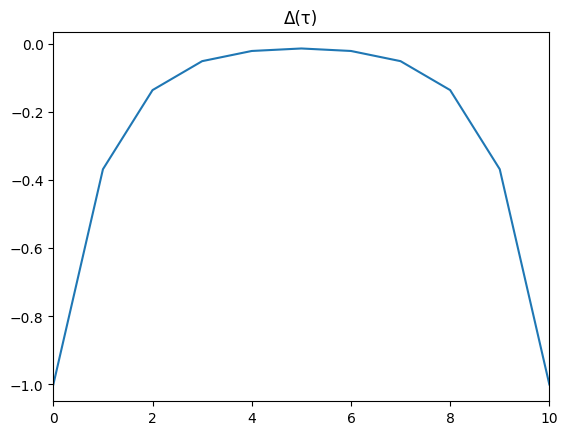

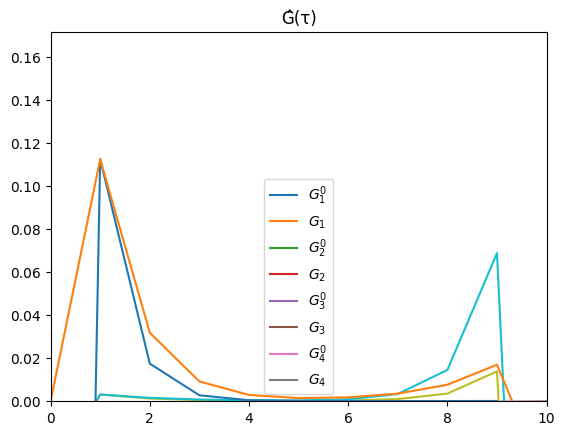

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/igor/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [5]:
contour, τ_grid, diagram = make_second_order_diag(nt = 2, nτ = 11, tmax = 1.0, τ_w_pos = 0.8, verbose = true)

vals = [diagram([τ.bpoint, τ_grid[2].bpoint, τ_grid[1].bpoint]) for τ in τ_grid]

for s in 1:4
    val_s = [d[s][2] for d in vals]
    val_s = vcat(val_s...)    
    plt.plot([-imag(τ.bpoint.val) for τ in τ_grid], imag.(val_s))
end

plt.ylim(bottom=0);

## Test a single value of the integrand

In [6]:
@show τ = [τ_grid[end-4].bpoint, τ_grid[end-6].bpoint, τ_grid[end-8].bpoint]
@show diagram(τ)

τ = [(τ_grid[end - 4]).bpoint, (τ_grid[end - 6]).bpoint, (τ_grid[end - 8]).bpoint] = Keldysh.BranchPoint[Keldysh.BranchPoint(0.0 - 6.0im, 0.6, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 4.0im, 0.4, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 2.0im, 0.2, Keldysh.imaginary_branch)]
diagram(τ) = Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}}(4 => (4, [0.0 + 3.705268756486367e-5im;;]), 2 => (2, [0.0 + 1.584110434826382e-5im;;]), 3 => (3, [0.0 + 3.705268756486367e-5im;;]), 1 => (1, [0.0 + 1.584110434826382e-5im;;]))


Dict{Int64, Tuple{Int64, Matrix{ComplexF64}}} with 4 entries:
  4 => (4, [0.0+3.70527e-5im;;])
  2 => (2, [0.0+1.58411e-5im;;])
  3 => (3, [0.0+3.70527e-5im;;])
  1 => (1, [0.0+1.58411e-5im;;])

# Compute reference value via Delaunay triangulation and integration

In [7]:
function make_ref_value(diagram, contour, τ_grid, τ_w_pos, order_min, order_max; verbose = false)
    b = contour[kd.imaginary_branch]
    τ_vals = [-imag(τ.bpoint.val) for τ in τ_grid]
    τ_w_idx = 1 + Int(τ_w_pos * (length(τ_vals) - 1))
    
    points, simplices = DelaunaySimplex.triangulate(τ_vals[1:τ_w_idx], 3);
    
    func_sector(z, y, x, sector) = -imag(diagram([b(z/β), b(y/β), b(x/β)])[sector][2][1, 1])
    scalar_integrand(x, sector) = func_sector(x[1], x[2], x[3], sector)
    
    orders = collect(order_min:1:order_max)
    delaunay_res = Array{Float64, 2}(undef, 0, 4)
    
    for order = orders
        val = [
            DelaunaySimplex.integrate_t3(points, simplices, order) do x
                [scalar_integrand(x[:, i], sector) for i = 1:size(x, 2)]
            end
            for sector = 1:4
        ]
        if verbose
           println("val($order)    = $val")
            if length(delaunay_res) > 0
                diff = val - delaunay_res[end, :]
                println("diff      = $diff")
            end
        end
        delaunay_res = cat(delaunay_res, val'; dims=1)
    end
    
    if verbose
        delaunay_errors = abs.(delaunay_res[1:end-1, :] .- delaunay_res[end, :]')        
        plt.semilogy(orders[2:end], delaunay_errors)
        plt.xlabel("integrator order")
        plt.ylabel("pairwise difference")
        plt.savefig("figure_delaunay_integration_convergence.pdf")
    end
    
    delaunay_res[end, :]
end;

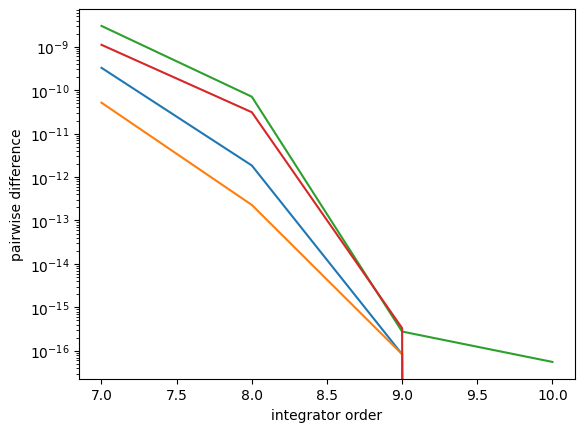

val(6)    = [-0.06379984933819405, -0.06381550800127937, -0.28263395652527723, -0.2781215844125249]
val(7)    = [-0.0637998490135754, -0.06381550805297442, -0.28263395344623704, -0.2781215832767411]
diff      = [3.24618651403874e-10, -5.1695051017652816e-11, 3.079040189479798e-9, 1.135783800343404e-9]
val(8)    = [-0.06379984901172973, -0.06381550805274644, -0.28263395351691184, -0.27812158330779163]
diff      = [1.845662511712476e-12, 2.279842981067759e-13, -7.067479934619314e-11, -3.1050551019262684e-11]
val(9)    = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169122, -0.27812158330779196]
diff      = [8.326672684688674e-17, 8.326672684688674e-17, -3.3306690738754696e-16, -3.3306690738754696e-16]
val(10)    = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169121, -0.27812158330779196]
diff      = [0.0, 0.0, 5.551115123125783e-17, 0.0]
890.079615 seconds (14.57 G allocations: 1.175 TiB, 16.09% gc time, 0.17% compilation time)


4-element Vector{Float64}:
 -0.06379984901172965
 -0.06381550805274636
 -0.2826339535169121
 -0.27812158330779196

In [8]:
@time make_ref_value(diagram, contour, τ_grid, 0.8, 6, 10, verbose = true)

## Numerical experiments with the 2nd order diagram (`ExpDiff` transformation)

HDF5 and plotting

In [14]:
using HDF5

function h5_write_results(group_name, ref, nτ, τ_qmc, N_list, N_samples_list, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        try 
            delete_object(file[group_name])
        catch KeyError end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "ntau", nτ)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_list", N_list)
        write(g, "N_samples_list", N_samples_list)
        write(g, "results", results)
        write(g, "div", div)
    end
end

function plot_N_convergence(pdf_filename, nτ, τ_qmc, N_list, N_samples_list, div)   
    fig, axes = plt.subplots(1, 2)
    
    # Plot div versus N_list
    for s=1:4
        axes[1].loglog(N_list, abs.(div[s, :]), lw=0.5, label = "\$s=$s\$")
    end
    for i = -3:5
        axes[1].loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
        axes[1].loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
    end
    
    axes[1].set_xlabel(raw"$N$")
    axes[1].set_ylabel(raw"$|P - P_{ref}|$")
    axes[1].set_xlim(N_list[1], N_list[end])
    axes[1].set_ylim(minimum(abs.(div)), maximum(abs.(div)))
    axes[1].legend(title="\$N_\\tau = $nτ, \\tau_{qmc} = $τ_qmc\$", loc="best")
    
    # Plot N_samples / N versus N
    axes[2].semilogx(N_list, N_samples_list ./ N_list, lw=0.5)
    
    axes[2].set_xlabel(raw"$N$")
    axes[2].set_ylabel(raw"$N_\mathrm{samples} / N$")
    
    fig.tight_layout()
    plt.savefig(pdf_filename)
end;

Scan a range of qRNG point numbers $N$ using incremental evaluation of the integral

In [15]:
function scan_N_range(diagram, contour, τ_grid, τ_w_pos, N_list::Vector{Int}; τ_qmc, verbose = false)
    τ_i = τ_grid[1]
    τ_w_idx = 1 + Int(τ_w_pos * (length(τ_grid) - 1))
    τ_w = τ_grid[τ_w_idx]
    
    N_steps = [N_list[1]]
    append!(N_steps, diff(N_list))
    N_samples_list = zeros(Int, length(N_list))
    chunks = zeros(Complex{Float64}, 4, length(N_steps))
    
    seq = SobolSeq(3)
    N = 0
    for (i, N_step) in collect(Iterators.enumerate(N_steps))        
        chunk, N_samples = qmc_time_ordered_integral(diagram, 3, contour,
                                                     τ_i.bpoint, τ_w.bpoint,
                                                     init = deepcopy(diagram.init_0),
                                                     seq = seq, τ = τ_qmc, N = N_step)
        chunk *= N_step
        chunks[:, i] = [chunk[s][2][1] for s = 1:4]
        N_samples_list[i] = N_samples
        
        if verbose
            println("Chunk $i: Sobol sequence points [$N; $(N + N_step)[: contribution = $(chunks[:, i])")
            flush(stdout)
        end
        N += N_step
    end
    
    results = cumsum(chunks, dims=2)
    for i = 1:length(N_steps)
        results[:, i] /= N_list[i]
    end
    (cumsum(N_samples_list), results)
end;

Scan a range of sequence points numbers $N$

In [16]:
nτ_list = [11, 21]
τ_w_pos = 0.8
τ_qmc_list = [0.5β, 1.0β, 2.0β, 4.0β]

N_list = round.(Int, exp10.(range(3, 7, length=500)))

for nτ in nτ_list
    contour, τ_grid, diagram = make_second_order_diag(nt = 2, nτ = nτ, tmax = 1.0, τ_w_pos = 0.8)
    @time ref = make_ref_value(diagram, contour, τ_grid, τ_w_pos, 9, 9)
    println("ref = $ref")
    
    for τ_qmc in τ_qmc_list    
        @time N_samples_list, results = scan_N_range(diagram, contour, τ_grid, τ_w_pos, N_list, τ_qmc = τ_qmc)
        div = results - (ref .* ones(ComplexF64, length(N_list))')
        
        h5_write_results("scan_N_range/ntau$(nτ)_tau_qmc$(τ_qmc)", ref, nτ, τ_qmc, N_list, N_samples_list, results, div)
    end
end

186.141900 seconds (3.51 G allocations: 289.812 GiB, 12.88% gc time, 0.00% compilation time)
ref = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169122, -0.27812158330779196]
2808.999273 seconds (50.08 G allocations: 4.049 TiB, 13.31% gc time, 0.05% compilation time)
618.624307 seconds (10.96 G allocations: 906.618 GiB, 13.53% gc time, 0.00% compilation time)
105.203472 seconds (1.85 G allocations: 152.469 GiB, 13.65% gc time)
 16.857188 seconds (284.77 M allocations: 23.385 GiB, 13.94% gc time)
1638.208495 seconds (28.51 G allocations: 2.320 TiB, 13.78% gc time)
ref = [-0.05041860359179201, -0.05039131816311713, -0.22304299175185008, -0.22111772657526615]
2912.822812 seconds (51.15 G allocations: 4.169 TiB, 13.73% gc time)
641.306551 seconds (11.20 G allocations: 934.443 GiB, 13.78% gc time)
108.927688 seconds (1.89 G allocations: 157.207 GiB, 13.83% gc time)
 17.258142 seconds (290.79 M allocations: 24.077 GiB, 13.69% gc time)


Plot results of the sequence points number scan

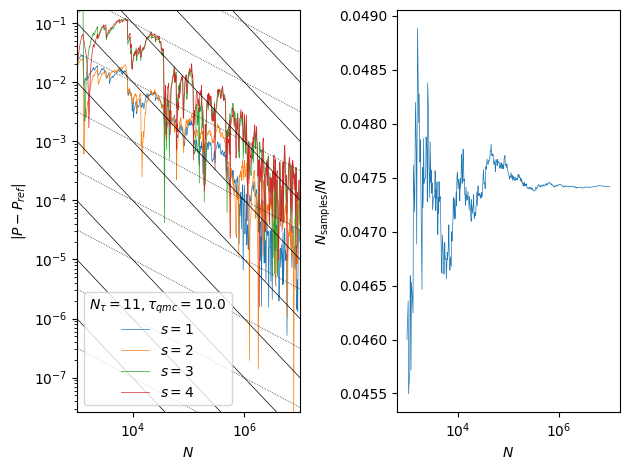

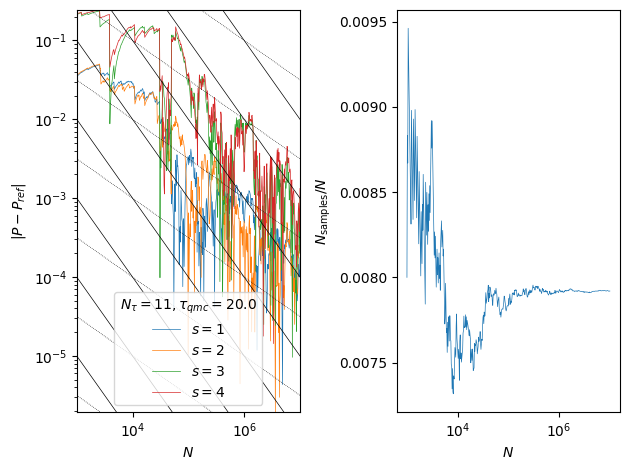

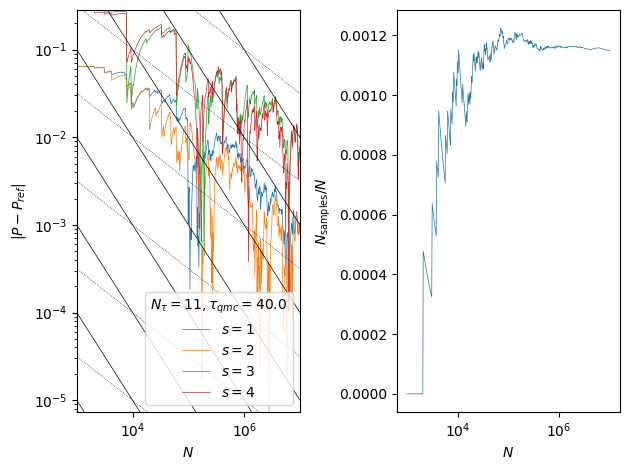

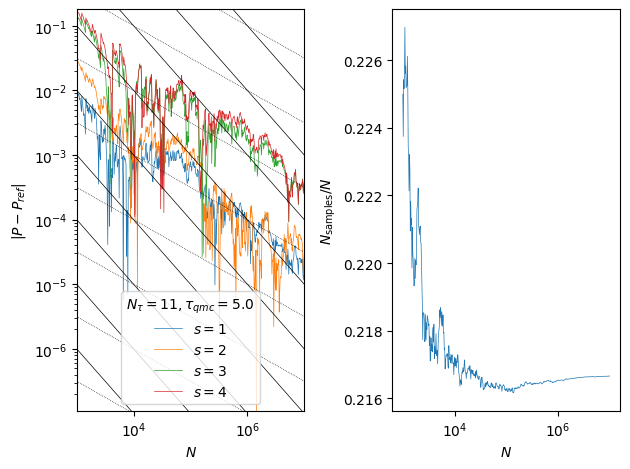

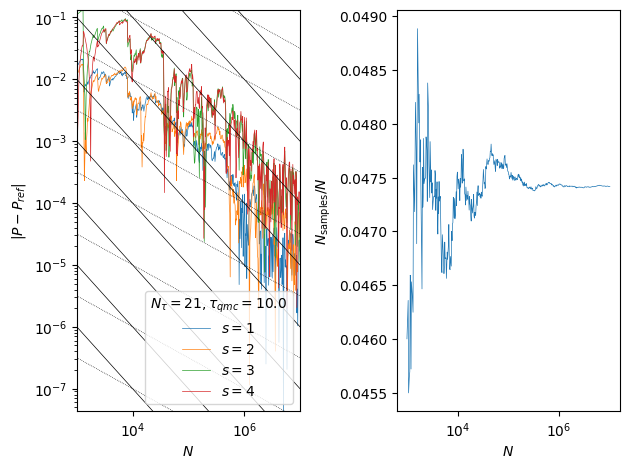

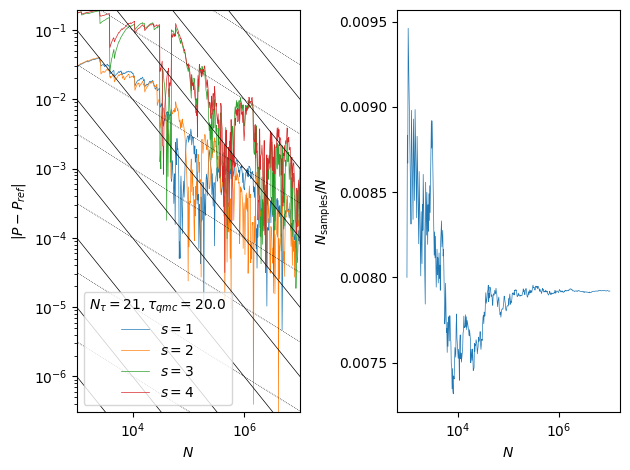

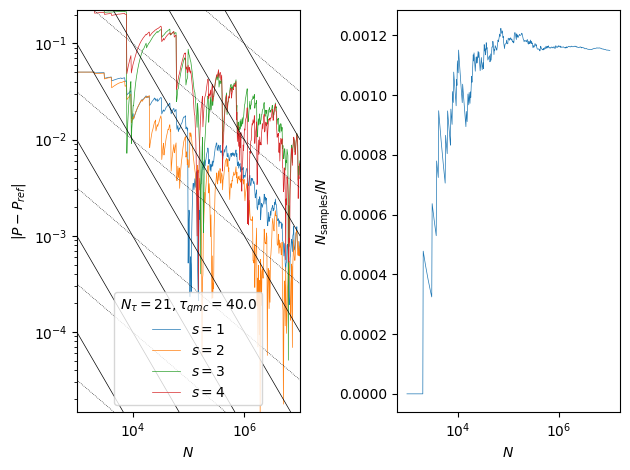

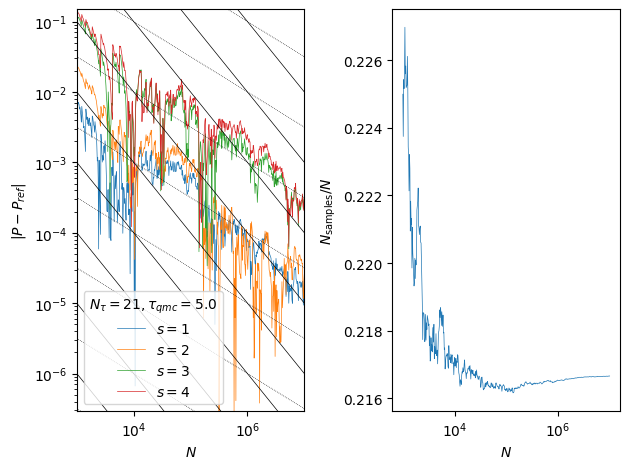

In [17]:
h5open("2nd_order_inchworm.h5", "r") do file
    for group in file["scan_N_range"]
        nτ = group["ntau"][]
        τ_qmc = group["tau_qmc"][]
        N_list = group["N_list"][:]
        N_samples_list = group["N_samples_list"][:]
        ref = group["ref"][]
        div = group["div"][:,:]
        plot_N_convergence("2nd_order_inchworm_N_scan_ntau$(nτ)_tau_qmc$(τ_qmc).pdf", nτ, τ_qmc, N_list, N_samples_list, div)
    end
end

## Numerical experiments with the 2nd order diagram (`Sort` and `Root` transformations)

HDF5 and plotting

In [20]:
using HDF5

function h5_write_results(group_name, ref, nτ, N_list, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        try 
            delete_object(file[group_name])
        catch KeyError end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "ntau", nτ)
        write(g, "N_list", N_list)
        write(g, "results", results)
        write(g, "div", div)
    end
end

function plot_N_convergence(pdf_filename, nτ, N_list, div)
    plt.figure()
    for s=1:4
        plt.loglog(N_list, abs.(div[s, :]), lw=0.5, label = "\$s=$s\$")
    end
    for i = -3:5
        plt.loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
        plt.loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
    end
    
    plt.xlabel(raw"$N$")
    plt.ylabel(raw"$|P - P_{ref}|$")
    plt.xlim(N_list[1], N_list[end])
    plt.ylim(minimum(abs.(div)), maximum(abs.(div)))
    plt.legend(title="\$N_\\tau = $nτ\$", loc="best")
    
    plt.savefig(pdf_filename)
end;

Scan a range of qRNG point numbers N using the `Sort` transformation and incremental evaluation of the integral

In [11]:
function scan_N_range_sort(diagram, contour, τ_grid, τ_w_pos, N_list::Vector{Int}; verbose = false)
    τ_i = τ_grid[1]
    τ_w_idx = 1 + Int(τ_w_pos * (length(τ_grid) - 1))
    τ_w = τ_grid[τ_w_idx]
    
    N_steps = [N_list[1]]
    append!(N_steps, diff(N_list))
    chunks = zeros(Complex{Float64}, 4, length(N_steps))
    
    seq = SobolSeq(3)
    N = 0
    for (i, N_step) in collect(Iterators.enumerate(N_steps))        
        chunk = qmc_time_ordered_integral_sort(diagram, 3, contour,
                                               τ_i.bpoint, τ_w.bpoint,
                                               init = deepcopy(diagram.init_0),
                                               seq = seq, N = N_step)
        chunk *= N_step
        chunks[:, i] = [chunk[s][2][1] for s = 1:4]
        
        if verbose
            println("Chunk $i: Sobol sequence points [$N; $(N + N_step)[: contribution = $(chunks[:, i])")
            flush(stdout)
        end
        N += N_step
    end
    
    results = cumsum(chunks, dims=2)
    for i = 1:length(N_steps)
        results[:, i] /= N_list[i]
    end
    results
end;

In [18]:
nτ_list = [11, 21]
τ_w_pos = 0.8

N_list = round.(Int, exp10.(range(2, 6, length=500)))

for nτ in nτ_list
    contour, τ_grid, diagram = make_second_order_diag(nt = 2, nτ = nτ, tmax = 1.0, τ_w_pos = 0.8)
    @time ref = make_ref_value(diagram, contour, τ_grid, τ_w_pos, 9, 9)
    println("ref = $ref")
    
    @time results = scan_N_range_sort(diagram, contour, τ_grid, τ_w_pos, N_list)
    div = results - (ref .* ones(ComplexF64, length(N_list))')

    h5_write_results("scan_N_range_sort/ntau$(nτ)", ref, nτ, N_list, results, div)
end

192.165239 seconds (3.51 G allocations: 289.812 GiB, 13.60% gc time)
ref = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169122, -0.27812158330779196]
1267.629770 seconds (23.03 G allocations: 1.859 TiB, 13.12% gc time)
1607.704958 seconds (28.51 G allocations: 2.320 TiB, 13.68% gc time)
ref = [-0.05041860359179201, -0.05039131816311713, -0.22304299175185008, -0.22111772657526615]
1591.848904 seconds (23.55 G allocations: 1.919 TiB, 13.36% gc time)


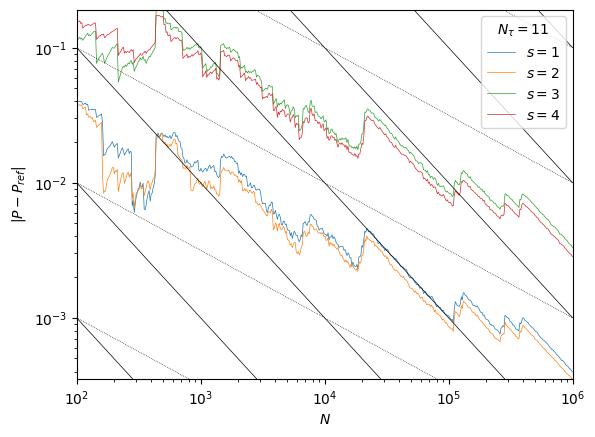

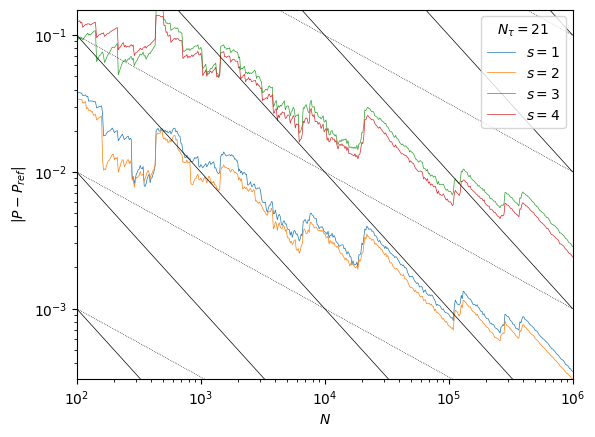

In [21]:
h5open("2nd_order_inchworm.h5", "r") do file
    for group in file["scan_N_range_sort"]
        nτ = group["ntau"][]
        N_list = group["N_list"][:]
        ref = group["ref"][]
        div = group["div"][:,:]
        plot_N_convergence("2nd_order_inchworm_N_scan_sort_ntau$(nτ).pdf", nτ, N_list, div)
    end
end

Scan a range of qRNG point numbers N using the `Root` transformation and incremental evaluation of the integral

In [22]:
function scan_N_range_root(diagram, contour, τ_grid, τ_w_pos, N_list::Vector{Int}; verbose = false)
    τ_i = τ_grid[1]
    τ_w_idx = 1 + Int(τ_w_pos * (length(τ_grid) - 1))
    τ_w = τ_grid[τ_w_idx]
    
    N_steps = [N_list[1]]
    append!(N_steps, diff(N_list))
    chunks = zeros(Complex{Float64}, 4, length(N_steps))
    
    seq = SobolSeq(3)
    N = 0
    for (i, N_step) in collect(Iterators.enumerate(N_steps))        
        chunk = qmc_time_ordered_integral_root(diagram, 3, contour,
                                               τ_i.bpoint, τ_w.bpoint,
                                               init = deepcopy(diagram.init_0),
                                               seq = seq, N = N_step)
        chunk *= N_step
        chunks[:, i] = [chunk[s][2][1] for s = 1:4]
        
        if verbose
            println("Chunk $i: Sobol sequence points [$N; $(N + N_step)[: contribution = $(chunks[:, i])")
            flush(stdout)
        end
        N += N_step
    end
    
    results = cumsum(chunks, dims=2)
    for i = 1:length(N_steps)
        results[:, i] /= N_list[i]
    end
    results
end;

In [23]:
nτ_list = [11, 21]
τ_w_pos = 0.8

N_list = round.(Int, exp10.(range(2, 6, length=500)))

for nτ in nτ_list
    contour, τ_grid, diagram = make_second_order_diag(nt = 2, nτ = nτ, tmax = 1.0, τ_w_pos = 0.8)
    @time ref = make_ref_value(diagram, contour, τ_grid, τ_w_pos, 9, 9)
    println("ref = $ref")
    
    @time results = scan_N_range_root(diagram, contour, τ_grid, τ_w_pos, N_list)
    div = results - (ref .* ones(ComplexF64, length(N_list))')
        
    h5_write_results("scan_N_range_root/ntau$(nτ)", ref, nτ, N_list, results, div)
end

213.931443 seconds (3.51 G allocations: 289.812 GiB, 14.38% gc time)
ref = [-0.06379984901172965, -0.06381550805274636, -0.2826339535169122, -0.27812158330779196]
1559.357138 seconds (23.03 G allocations: 1.859 TiB, 13.38% gc time, 0.03% compilation time)
1832.587400 seconds (28.51 G allocations: 2.320 TiB, 14.29% gc time)
ref = [-0.05041860359179201, -0.05039131816311713, -0.22304299175185008, -0.22111772657526615]
2029.952758 seconds (23.55 G allocations: 1.919 TiB, 13.08% gc time)


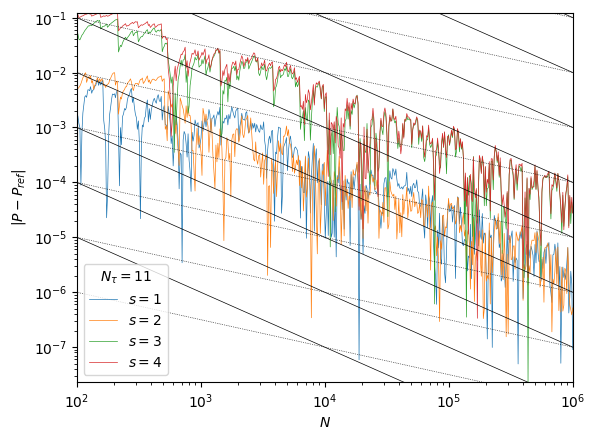

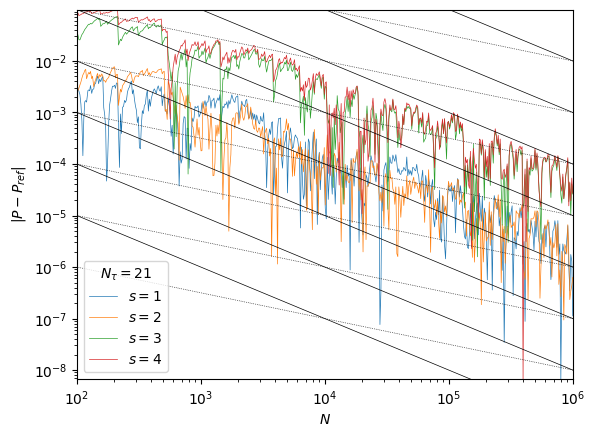

In [24]:
h5open("2nd_order_inchworm.h5", "r") do file
    for group in file["scan_N_range_root"]
        nτ = group["ntau"][]
        N_list = group["N_list"][:]
        ref = group["ref"][]
        div = group["div"][:,:]
        plot_N_convergence("2nd_order_inchworm_N_scan_root_ntau$(nτ).pdf", nτ, N_list, div)
    end
end